# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import phik
from phik.report import plot_correlation_matrix
from phik import report
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
import shap
from shap import Explanation
from catboost.utils import get_confusion_matrix
import optuna

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [12]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
759,i47017449U,Kia Rio X-line,economy,petrol,4.00,2012,29052,2019,30.65,engine_fuel
1401,p15480858O,Smart ForTwo,economy,petrol,5.48,2013,41678,2021,47.31,engine_check
1370,i-2296057M,Hyundai Solaris,economy,petrol,5.20,2015,86195,2018,36.48,electro_bug
1871,F-7066018m,Kia Rio X,economy,petrol,4.26,2015,78179,2016,33.19,wheel_shake
2318,C14604474J,Smart ForTwo,economy,petrol,3.52,2015,77325,2022,55.90,engine_ignition


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [13]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
32458,V21042985w,C-1546256l,Y1Y,2020-02-19,7.45,33,655,42,155.000000,1,605.550589,0,-4.927841,-1.100
254593,R77024623z,R28123139u,g1Q,2020-01-17,3.66,46,360,44,83.000000,1,1171.604785,0,-6.432501,-0.001
710124,C47558306g,y-1004097K,F1t,2020-01-17,0.50,59,528,58,125.578361,1,2337.909487,0,-0.714891,15.197
85255,A47842528Q,G-1501141U,H1z,2020-03-30,3.83,20,995,50,71.000000,1,826.113378,0,19.679379,-1.645
69635,p34956557T,F-1306753r,L1C,2020-01-19,4.53,52,513,44,186.989275,0,1295.437264,0,-4.104795,30.336


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [14]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
2543,37,9.0,527,9.0,Y21000972m,1,2020-7-1
13647,26,7.8,263,48.0,z16853280H,1,2019-9-8
13275,20,7.3,1228,2.0,R94104453B,1,2020-12-30
5847,43,8.9,1814,12.0,k49611824S,0,2021-8-29
9475,18,9.0,1676,21.0,L12912314L,1,2018-6-4


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [15]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
53664,c-1909821W,YV,2020-11-25 0:4,repair,5.0,21
125502,f-2054559Z,CV,2019-5-16 15:21,reparking,1.0,32
138047,q78677693j,VH,2019-10-12 16:49,repair,4.5,5
4398,O13657804w,ZB,2020-4-16 4:7,refuel_check,10.0,65
89979,y-2198122N,UR,2020-12-1 19:20,refuel_check,1.0,26


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

In [16]:
df_driver_info = driver_info.groupby("user_id", as_index=False).agg(
    # минимальный рейтинг за все поездки
    user_rating_min=("user_rating", "min"),
    # средний рейтинг за все поездки
    user_rating_mean=("user_rating", "mean"),
    # общее кол-во инцидентов
    user_time_accident_sum=("user_time_accident", "sum"),
    # среднее кол-во инцидентов
    user_time_accident_mean=("user_time_accident", "mean")
)

In [17]:
df_rides_driver_info = pd.merge(rides_info, df_driver_info, how='left', on='user_id')

In [18]:
df_rides_driver_info = df_rides_driver_info.groupby("car_id", as_index=False).agg(
    # минимальный рейтинг за все поездки
    rating_min=("rating", "min"),
    # средний рейтинг за все поездки
    rating_mean=("rating", "mean"),
    # общее кол-во километров, которые машина проехала
    distance_sum=("distance", "sum"),
    # максимальная скорость
    speed_max_max=("speed_max", "max"),
    # общее кол-во поездок для каждой машины
    ride_id_count=("ride_id", "count"),

    # средний показатель датчиков состояния машины
    deviation_normal_min=("deviation_normal", "mean"),
    # оценка манеры вождения
    user_ride_quality_mean=("user_ride_quality", "mean"),
    # общая длительность поездок
    ride_duration_sum=("ride_duration", "sum"),
    
    # поездки с рейтингом ниже 4
    rating_below_4=("rating", lambda x: (x < 4).mean() * 100),
    # поездки с рейтингом 4 и выше
    rating_above_4=("rating", lambda x: (x >= 4).mean() * 100),
    # общая сумма поездок
    ride_cost_sum=("ride_cost", "sum"),
    # средняя скорость поездок
    speed_avg_mean=("speed_avg", "mean"),
    # дисперсия скорости поездок
    speed_avg_var=("speed_avg", "var"),
    # общая сумма остановок
    stop_times_sum=("stop_times", "sum"),
    # общая сумма поездок с дозаправками
    refueling_sum=("refueling", "sum"),

    # минимальный рейтинг пользователей 
    user_rating_min=("user_rating_min", "min"),
    # средний рейтинг пользователей 
    user_rating_mean=("user_rating_mean", "mean"),
    # общее кол-во инцидентов пользователей 
    user_time_accident_sum=("user_time_accident_sum", "sum"),
    # среднее кол-во инцидентов пользователей 
    user_time_accident_mean=("user_time_accident_mean", "mean")
)

In [19]:
df_fix_info = fix_info.groupby("car_id", as_index=False).agg(
    # общая длительность работ
    work_duration_min=("work_duration", "sum"),
    # общая степень износа
    destroy_degree_sum=("destroy_degree", "sum"),
    # средняя степень износа
    destroy_degree_mean=("destroy_degree", "mean")
)

In [20]:
df_final = car_train.copy()
df_final = pd.merge(df_final, df_rides_driver_info, how='left', on='car_id')
df_final = pd.merge(df_final, df_fix_info, how='left', on='car_id')
df_final

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,speed_avg_var,stop_times_sum,refueling_sum,user_rating_min,user_rating_mean,user_time_accident_sum,user_time_accident_mean,work_duration_min,destroy_degree_sum,destroy_degree_mean
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,94.803435,630,0,6.2,8.229885,2056.0,17.724138,933,106.7,3.048571
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,230.524218,145,0,6.7,7.988506,1212.0,6.965517,873,102.1,2.917143
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,93.612684,140,0,6.2,7.843103,1701.0,9.775862,915,130.9,3.740000
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,219.487343,150,0,8.0,8.524138,2299.0,19.991304,1007,143.0,4.085714
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,217.708890,132,0,6.5,8.112069,1891.0,15.758333,981,135.8,3.880000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,...,117.569231,509,0,6.3,8.124138,2384.0,20.203390,814,132.6,3.900000
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,...,100.777257,134,0,7.1,8.150575,2183.0,18.041322,873,65.8,1.935294
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,...,96.919042,144,0,6.2,7.783908,1532.0,8.804598,797,94.6,2.782353
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,87.021992,609,0,6.0,8.084483,1990.0,17.008547,857,117.0,3.441176


## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [15]:
cols2drop = ['car_id', 'user_id', 'ride_id', 'worker_id', 'ride_id_count', 'model', 'ride_date', 'first_ride_date', 'fix_date']
df_final = df_final.drop(cols2drop, axis=1)

#### Линейная корреляция

In [68]:
df_lin_corr = df_final.copy()
cols2drop = ['car_type', 'fuel_type', 'work_type']
df_lin_corr = df_lin_corr.drop(cols2drop, axis=1)

df_lin_corr = df_lin_corr.drop('target_class', axis=1)

categorical_to_exclude = df_lin_corr.select_dtypes(include=['object']).columns.tolist()
df_linear_corr = df_lin_corr.drop(categorical_to_exclude, axis=1, errors = 'ignore')

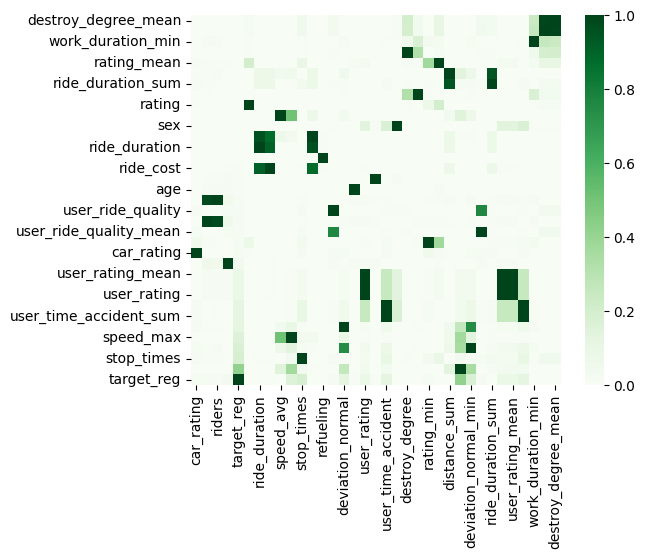

In [71]:
corrs = df_lin_corr.dropna().corr().round(3).sort_values('target_reg')
res = sns.heatmap(corrs,
            cmap = 'Greens',
            square=True,
            vmin = 0)

На данном графике мы можем видеть, что регрессионный таргет сильно коррелирует с колонкой
- speed_max_max (максимальная скорость)

Других корреляций с регрессионным таргетом не наблюдается, но т.к данный метод не подходит для категориальных признаков, это не удивительно.

#### Phik

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'rating', 'ride_duration', 'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance', 'refueling', 'user_ride_quality', 'deviation_normal', 'age', 'user_rating', 'user_rides', 'user_time_accident', 'sex', 'destroy_degree', 'work_duration', 'rating_min', 'rating_mean', 'distance_sum', 'speed_max_max', 'ride_id_count', 'deviation_normal_min', 'user_ride_quality_mean', 'ride_duration_sum', 'user_rating_min', 'user_rating_mean', 'user_time_accident_sum', 'work_duration_min', 'destroy_degree_sum', 'destroy_degree_mean']


c:\Users\savsp\AppData\Local\Programs\Python\Python312\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable ride_id_count for analysis 1. Dropping this column
  warnings.warn(


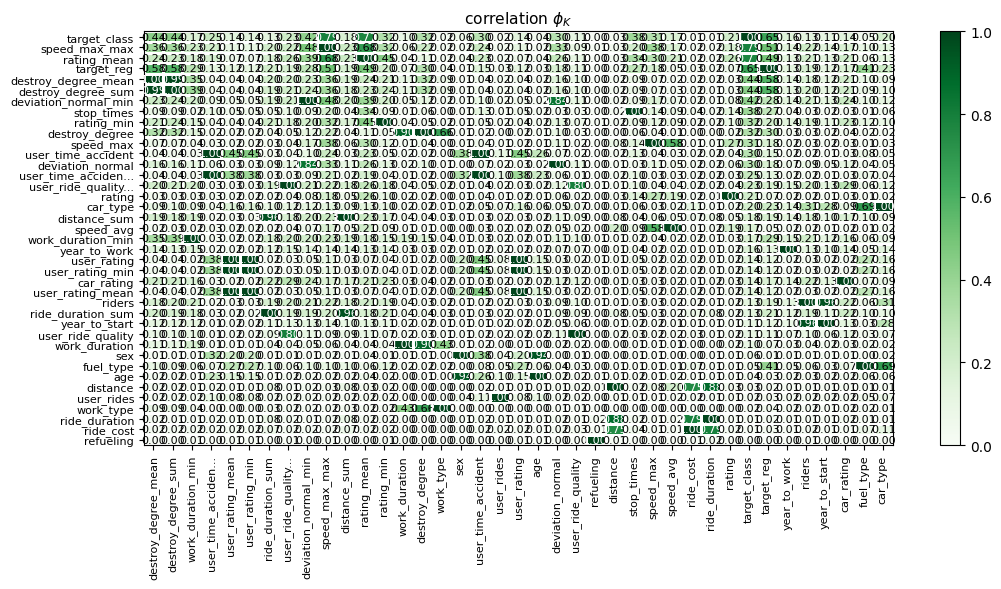

In [41]:
df_phik = df_final.copy()
phik_overview = df_phik.phik_matrix().round(2).sort_values('target_class')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

In [72]:
significance_overview = df_phik.significance_matrix().fillna(0).round(1).sort_values('target_reg')

plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=0, vmax=1, color_map="Greens",
                        title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'rating', 'ride_duration', 'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance', 'refueling', 'user_ride_quality', 'deviation_normal', 'age', 'user_rating', 'user_rides', 'user_time_accident', 'sex', 'destroy_degree', 'work_duration', 'rating_min', 'rating_mean', 'distance_sum', 'speed_max_max', 'ride_id_count', 'deviation_normal_min', 'user_ride_quality_mean', 'ride_duration_sum', 'user_rating_min', 'user_rating_mean', 'user_time_accident_sum', 'work_duration_min', 'destroy_degree_sum', 'destroy_degree_mean']


c:\Users\savsp\AppData\Local\Programs\Python\Python312\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable ride_id_count for analysis 1. Dropping this column
  warnings.warn(


На графиках выше видно, что регрессионный таргет коррелирует с колонками:
- destroy_degree_mean (степень износа машины)
- destroy_degree_sum (степень износа машины)
- user_time_accident (число инцидентов водителя)
- deviation_normal_min (показатель датчиков машины)
- speed_max_max (максимальная скорость)
- rating_mean (рейтинг, поставленный водителем)
- destroy_degree (степень износа машины)
- fuel_type (тип топлива машины)
- car_type (класс машины)

что выглядит как логичное заключение, т.к признаки выглядят достаточно сильными.

#### Permutation Importance

In [45]:
df_permute = df_final.copy()
drop_cols = ['car_id', 'ride_date', 'first_ride_date', 'fix_date', 'target_class']
cat_cols = ['car_type', 'fuel_type', 'work_type']

X = df_permute.drop(drop_cols, axis=1, errors = 'ignore')
y = df_permute['target_class'].fillna(0)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1)
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.130105
0:	learn: 1.5426852	test: 1.5430525	best: 1.5430525 (0)	total: 33.5s	remaining: 9h 17m 28s
100:	learn: 0.0713709	test: 0.0715461	best: 0.0715461 (100)	total: 1h 40m 49s	remaining: 14h 57m 25s
200:	learn: 0.0202000	test: 0.0202580	best: 0.0202580 (200)	total: 2h 30m 58s	remaining: 10h 8s
300:	learn: 0.0070862	test: 0.0071077	best: 0.0071077 (300)	total: 3h 21m 25s	remaining: 7h 47m 45s
400:	learn: 0.0025702	test: 0.0025771	best: 0.0025771 (400)	total: 4h 11m 44s	remaining: 6h 16m 2s
500:	learn: 0.0010221	test: 0.0010257	best: 0.0010257 (500)	total: 5h 2m 11s	remaining: 5h 59s
600:	learn: 0.0004417	test: 0.0004428	best: 0.0004428 (600)	total: 5h 50m 58s	remaining: 3h 53m
700:	learn: 0.0002551	test: 0.0002557	best: 0.0002557 (700)	total: 6h 34m 55s	remaining: 2h 48m 27s
800:	learn: 0.0001658	test: 0.0001662	best: 0.0001662 (800)	total: 7h 17m 26s	remaining: 1h 48m 40s
900:	learn: 0.0001252	test: 0.0001255	best: 0.0001255 (900)	total: 7h 58m 34s	remaining: 52m

In [48]:
# Посмотрим на важность признаков катбуста
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,rating_mean,19.098252
1,speed_max_max,15.993347
2,target_reg,14.220129
3,deviation_normal_min,6.101844
4,user_ride_quality_mean,5.759443
5,rating_min,4.406403
6,destroy_degree_mean,4.380828
7,work_duration_min,4.096876
8,destroy_degree_sum,3.988765
9,distance_sum,3.788095


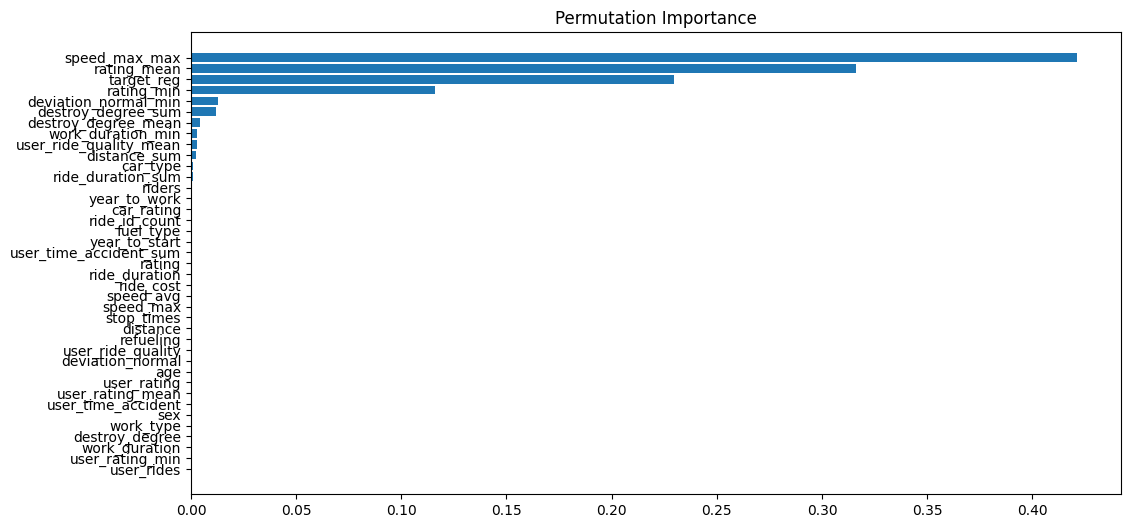

In [49]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

Здесь можно заметить, что значимость признаков выстраивается следующим образом:
- speed_max_max
- rating_min
- deviation_normal_min
- destroy_degree_sum
- destroy_degree_mean
- work_duration_min
- user_ride_quality_mean
- distance_sum
- car_type
- ride_duration_sum<br/>
...   ...   ...

Максимальная скорость, рейтинг, степень износа машины находятся в топе, что лишь подтверждает предыдущие результаты.
Можем присмотреться к данным результатам и продолжить анализ.

#### SHAP values

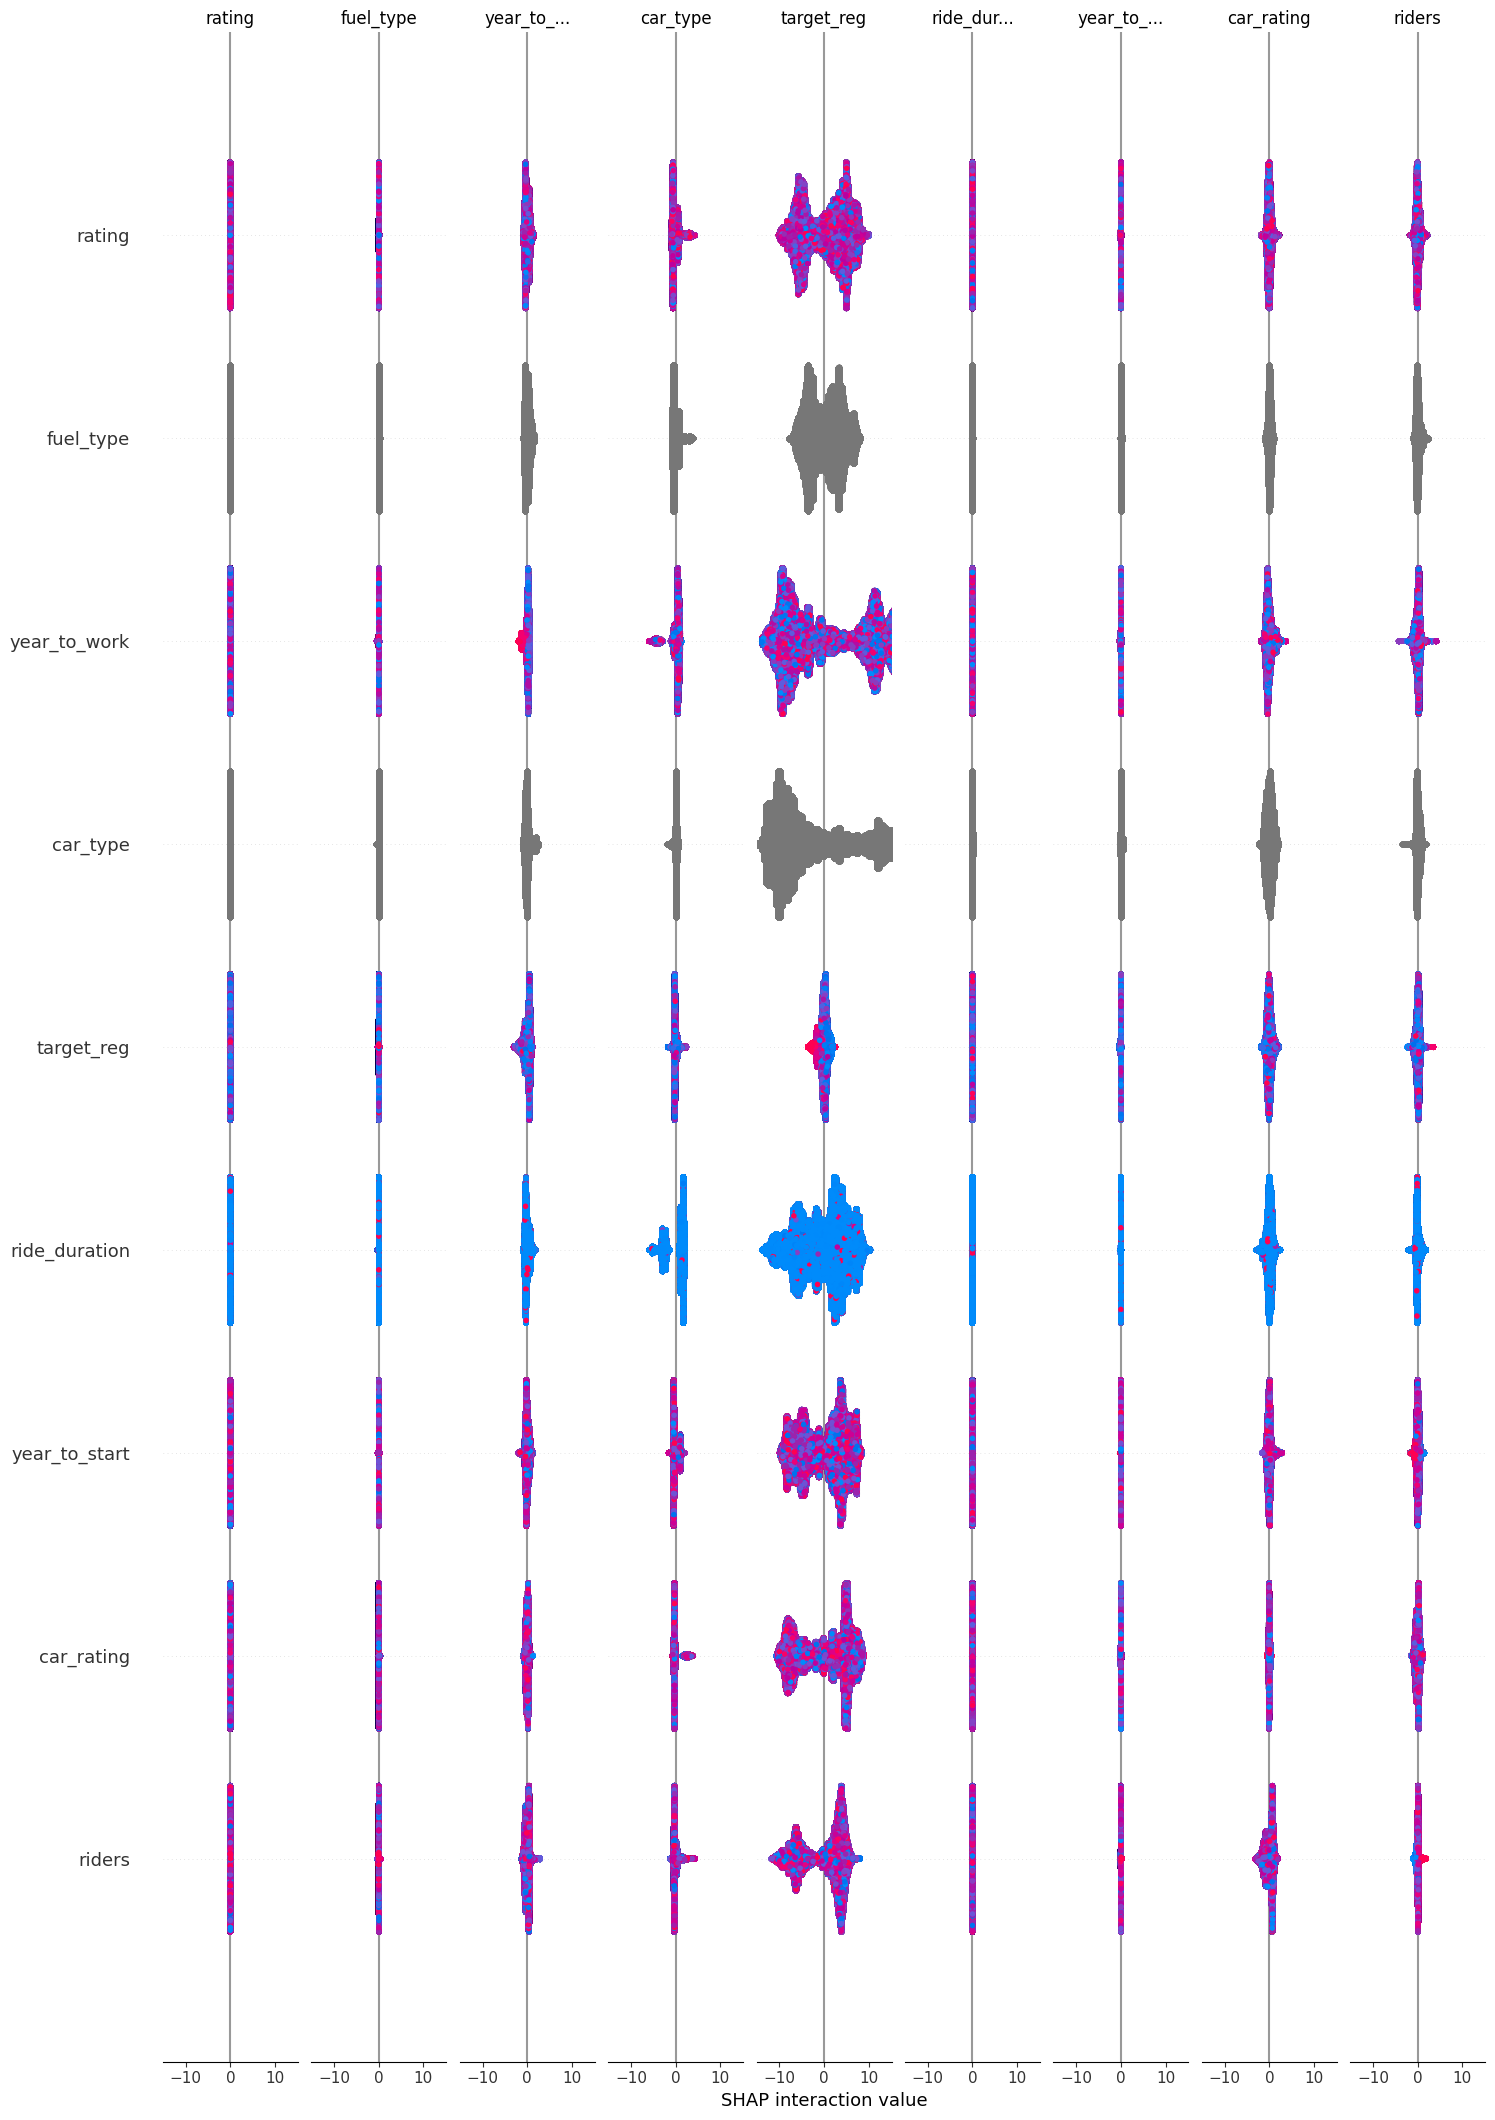

In [50]:
# Посмотрим на SHAP values
explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25)

Результат данного графика выглядит несколько неожиданным. Такие признаки, как "класс машины" и "тип топлива", вероятно, не важны для предсказания класса и их можно попробовать откинуть.

На основании выполненного задания можно подвести итог и сделать следующие выводы.<br/>
Линейная корреляция работает быстро, не улавливает нелинейные зависимости и не подходит для категориальных признаков.<br/>
Phik корреляция улавливает зависимость между категориальными признаками, но работает достаточно долго.<br/>
Permutation importance подходит для отсеивания признаков, но нет гарантии, что низкий по важности признак не снизит точность модели.<br/>
SHAP values также неплохо себя показал и увидел еще несколько признаков, которые некоторые методы фильтрации не выявили.

На данном этапе существует ряд признаков, которые потенциально можно удалить, но этого пока не требуется по условию.

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [21]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

> <br/>Выполнена аггрегация финального датасета на основании фидбэка по Домашнему заданию №1. <br/><br/>

In [22]:
df_final

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,speed_avg_var,stop_times_sum,refueling_sum,user_rating_min,user_rating_mean,user_time_accident_sum,user_time_accident_mean,work_duration_min,destroy_degree_sum,destroy_degree_mean
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,94.803435,630,0,6.2,8.229885,2056.0,17.724138,933,106.7,3.048571
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,230.524218,145,0,6.7,7.988506,1212.0,6.965517,873,102.1,2.917143
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,93.612684,140,0,6.2,7.843103,1701.0,9.775862,915,130.9,3.740000
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,219.487343,150,0,8.0,8.524138,2299.0,19.991304,1007,143.0,4.085714
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,217.708890,132,0,6.5,8.112069,1891.0,15.758333,981,135.8,3.880000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,...,117.569231,509,0,6.3,8.124138,2384.0,20.203390,814,132.6,3.900000
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,...,100.777257,134,0,7.1,8.150575,2183.0,18.041322,873,65.8,1.935294
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,...,96.919042,144,0,6.2,7.783908,1532.0,8.804598,797,94.6,2.782353
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,87.021992,609,0,6.0,8.084483,1990.0,17.008547,857,117.0,3.441176


In [23]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   car_id                   2337 non-null   object 
 1   model                    2337 non-null   object 
 2   car_type                 2337 non-null   object 
 3   fuel_type                2337 non-null   object 
 4   car_rating               2337 non-null   float64
 5   year_to_start            2337 non-null   int64  
 6   riders                   2337 non-null   int64  
 7   year_to_work             2337 non-null   int64  
 8   target_reg               2337 non-null   float64
 9   target_class             2337 non-null   object 
 10  rating_min               2337 non-null   float64
 11  rating_mean              2337 non-null   float64
 12  distance_sum             2337 non-null   float64
 13  speed_max_max            2337 non-null   float64
 14  ride_id_count           

In [ ]:
df_final.dtypes.value_counts()

float64    18
int64       9
object      5
Name: count, dtype: int64

In [28]:
features2drop = ["car_id"] # то, что надо выбросить

In [26]:
targets = ["target_class", "target_reg"] # таргеты

In [30]:
cat_cols = df_final.select_dtypes(include=['object']).columns
cat_cols = cat_cols.drop(features2drop, errors='ignore')
cat_cols = cat_cols.drop(targets, errors='ignore')
cat_cols = cat_cols.tolist()

print(cat_cols)
print(len(cat_cols))

['model', 'car_type', 'fuel_type']
3


In [31]:
cat_features = cat_cols # категориальные признаки

In [32]:
num_cols = df_final.select_dtypes(include=np.number).columns
num_cols = num_cols.drop(features2drop, errors='ignore')
num_cols = num_cols.drop(targets, errors='ignore')
num_cols = num_cols.tolist()

print(num_cols)
print(len(num_cols))

['car_rating', 'year_to_start', 'riders', 'year_to_work', 'rating_min', 'rating_mean', 'distance_sum', 'speed_max_max', 'ride_id_count', 'deviation_normal_min', 'user_ride_quality_mean', 'ride_duration_sum', 'rating_below_4', 'rating_above_4', 'ride_cost_sum', 'speed_avg_mean', 'speed_avg_var', 'stop_times_sum', 'refueling_sum', 'user_rating_min', 'user_rating_mean', 'user_time_accident_sum', 'user_time_accident_mean', 'work_duration_min', 'destroy_degree_sum', 'destroy_degree_mean']
26


In [33]:
num_features = num_cols # числовые признаки

In [34]:
print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные:', targets)

Категориальные признаки: 3 ['model', 'car_type', 'fuel_type']
Числовые признаки: 26 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'rating_min', 'rating_mean', 'distance_sum', 'speed_max_max', 'ride_id_count', 'deviation_normal_min', 'user_ride_quality_mean', 'ride_duration_sum', 'rating_below_4', 'rating_above_4', 'ride_cost_sum', 'speed_avg_mean', 'speed_avg_var', 'stop_times_sum', 'refueling_sum', 'user_rating_min', 'user_rating_mean', 'user_time_accident_sum', 'user_time_accident_mean', 'work_duration_min', 'destroy_degree_sum', 'destroy_degree_mean']
Целевые переменные: ['target_class', 'target_reg']


train (2337, 32)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,speed_avg_var,stop_times_sum,refueling_sum,user_rating_min,user_rating_mean,user_time_accident_sum,user_time_accident_mean,work_duration_min,destroy_degree_sum,destroy_degree_mean
931,V-2169580X,Renault Kaptur,standart,petrol,6.16,2012,21819,2022,28.70,engine_fuel,...,209.118065,140,0,6.1,8.038506,1793.0,14.007812,877,117.5,3.455882
1442,H17549143D,Hyundai Solaris,economy,petrol,5.06,2015,92005,2018,38.95,break_bug,...,96.255432,130,0,6.5,8.063793,1313.0,7.545977,762,103.7,3.050000
555,G62087174h,Renault Kaptur,standart,petrol,4.60,2011,2306,2020,38.81,electro_bug,...,188.010631,135,0,6.4,8.074713,1376.0,7.908046,902,136.0,3.885714


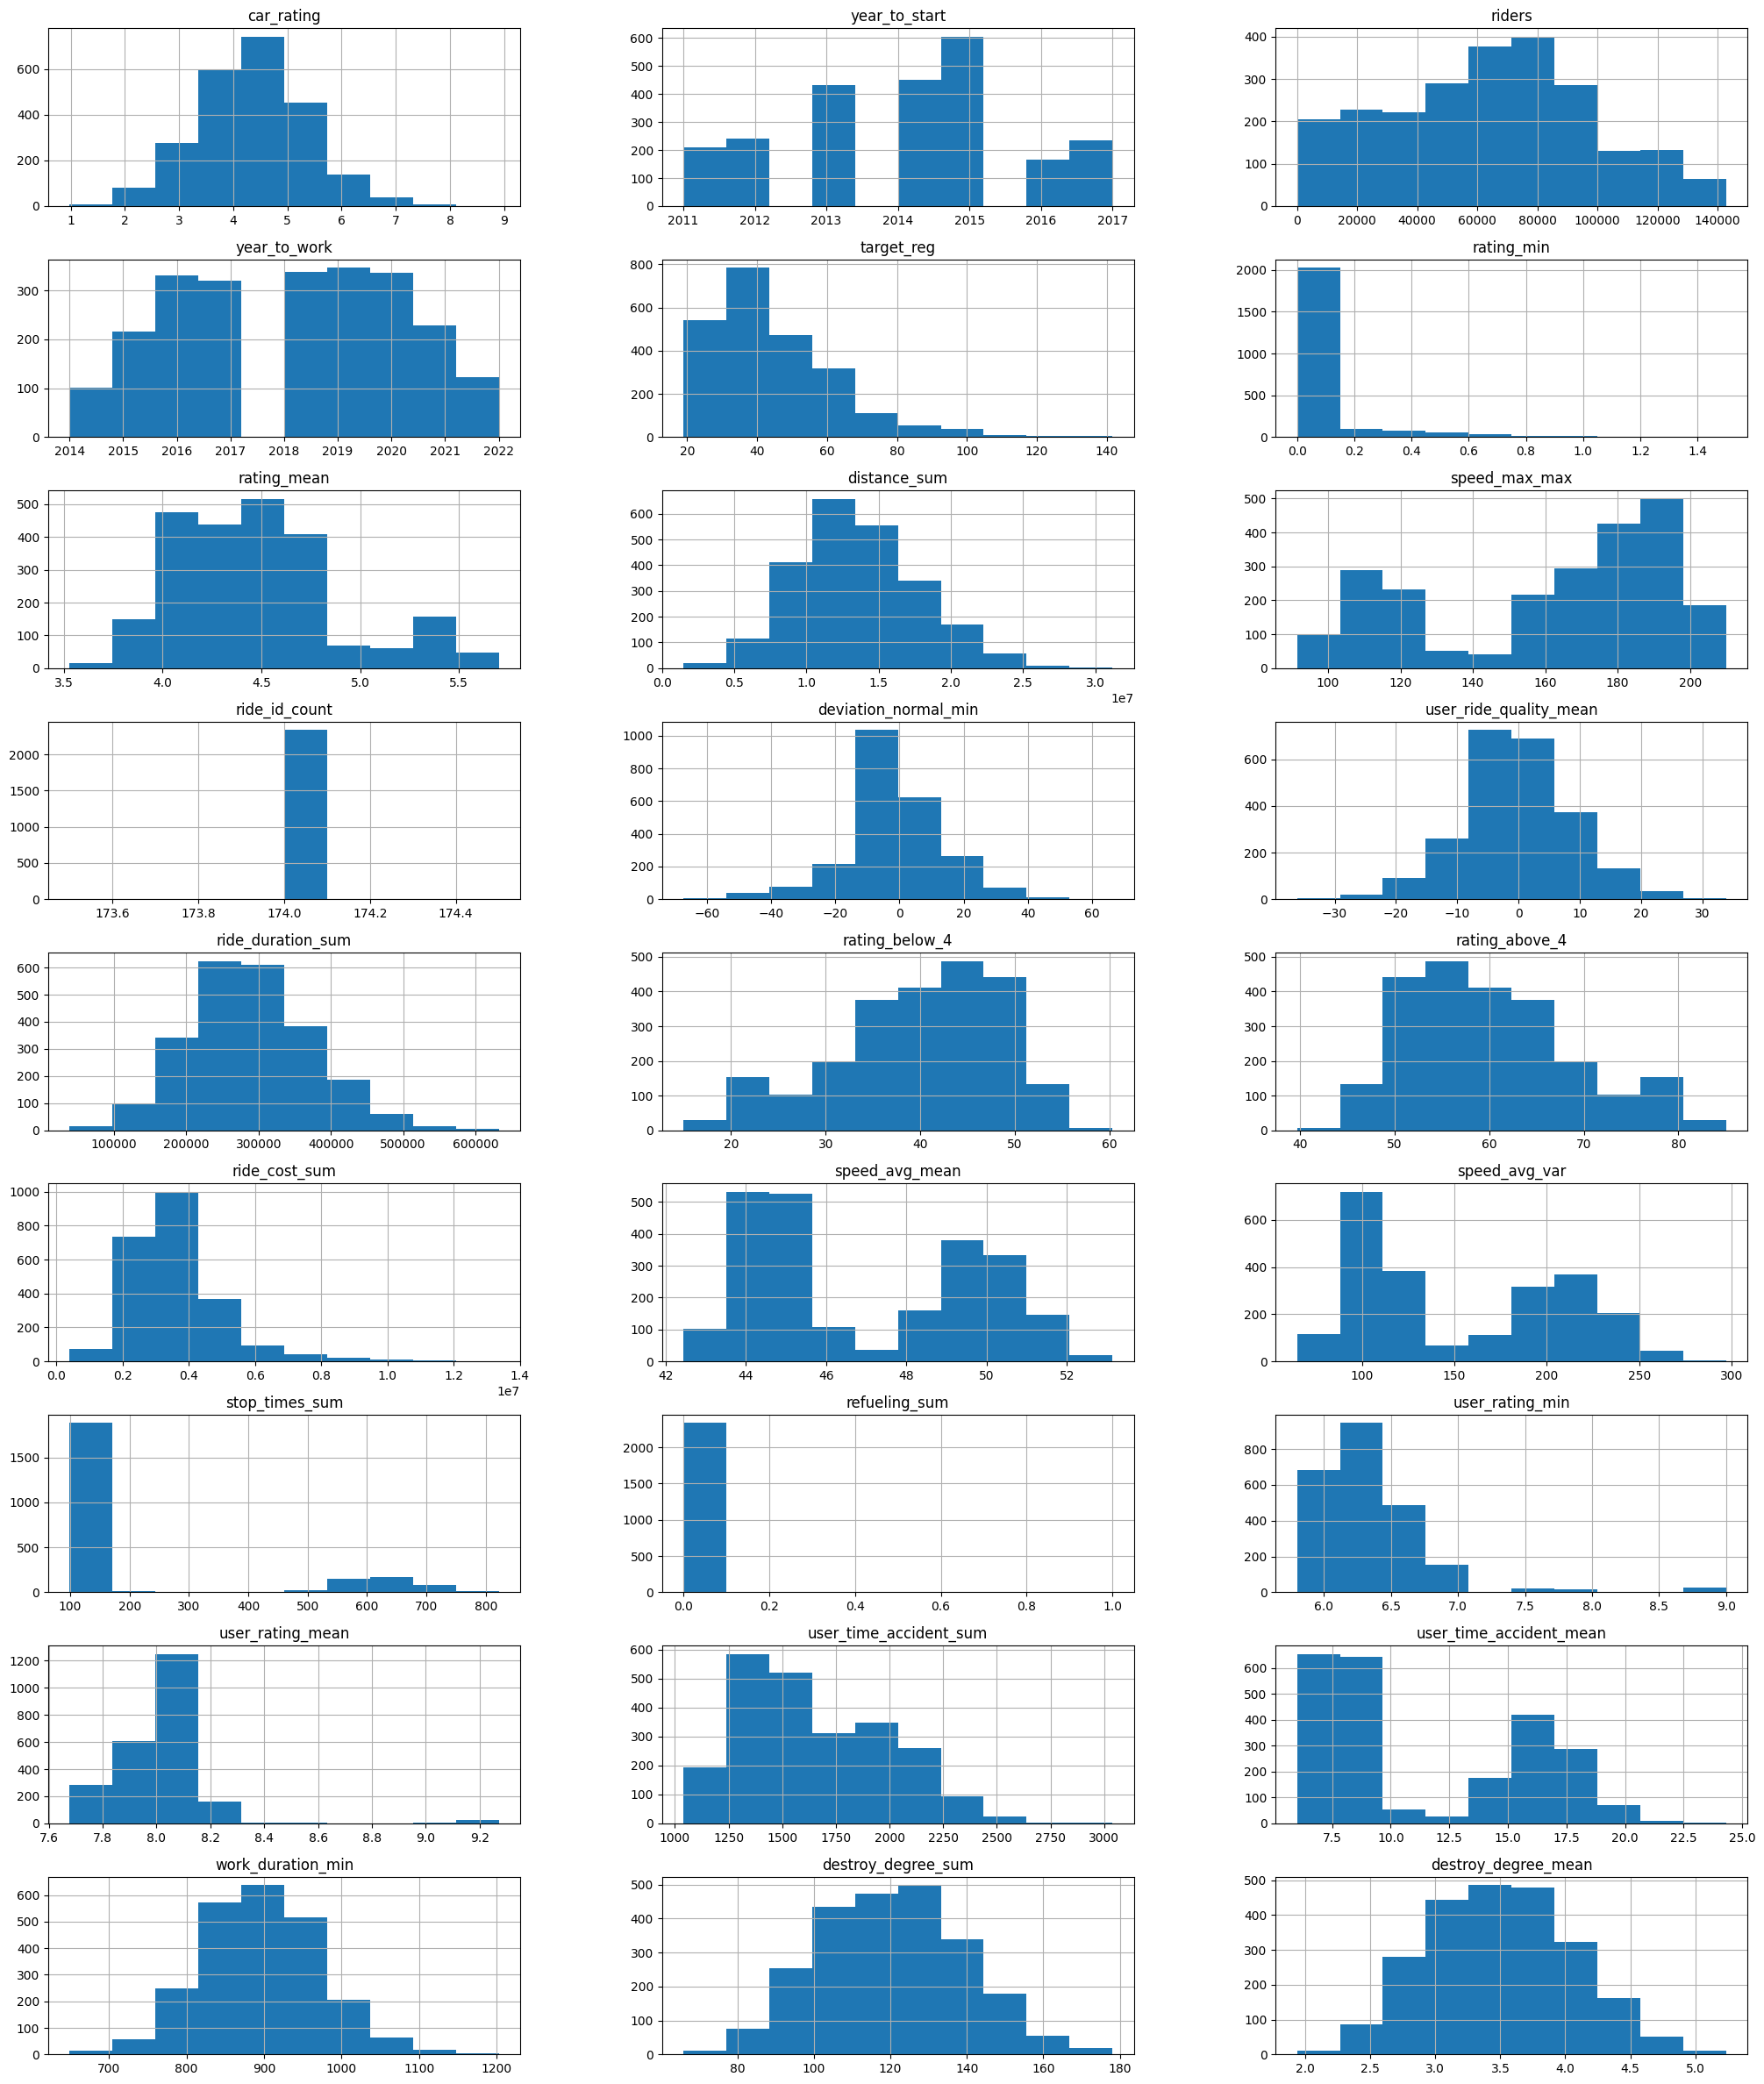

In [24]:
train = df_final.copy()
print("train", train.shape)

train.hist(figsize=(25, 30), layout=(-1, 3))
train.sample(3)

In [35]:
# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print("cat_features", cat_features)
print("num_features", len(num_features))
print("targets", targets)

for c in cat_features:  # Избавлямся от NaN'ов
    train[c] = train[c].astype(str)

cat_features ['model', 'car_type', 'fuel_type']
num_features 26
targets ['target_class', 'target_reg']


In [36]:
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
clf = CatBoostClassifier(iterations=100,
                         thread_count=-1,
                         random_seed=42,
                         cat_features=cat_features)

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=50,
)

Learning rate set to 0.263488
0:	learn: 1.1090385	test: 1.1158755	best: 1.1158755 (0)	total: 207ms	remaining: 20.5s


99:	learn: 0.0184274	test: 0.0477176	best: 0.0477176 (99)	total: 8.36s	remaining: 0us

bestTest = 0.04771755041
bestIteration = 99



Настройку гиперпараметров не делаем, т.к это не требуется по условию

In [37]:
class_predictions = clf.predict(X_test)
class_report = classification_report(y_test, class_predictions)

print(f'Classification Report:\n {class_report}')

Classification Report:
                  precision    recall  f1-score   support

    another_bug       0.97      0.98      0.97        58
      break_bug       0.98      1.00      0.99        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       1.00      0.98      0.99        49
    engine_fuel       0.98      1.00      0.99        58
engine_ignition       1.00      1.00      1.00        58
engine_overheat       1.00      1.00      1.00        48
     gear_stick       1.00      0.98      0.99        51
    wheel_shake       0.97      0.95      0.96        39

       accuracy                           0.99       468
      macro avg       0.99      0.99      0.99       468
   weighted avg       0.99      0.99      0.99       468



Для оценки качества обучения, по условию, используем метрику `accuracy`.<br/>
Наша `CatBoostClassifier` модель показывает точность: 0.99<br/>

Видно, что модель ошиблась на:

- wheel_shake
- another_bug

и чуть меньше на:

- break_bug
- engine_check
- engine_fuel
- gear_stick

Результаты достаточно неплохие, но это не означает, что на реальных тестовых данных (в общем случае) результат будет аналогичен. 

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

Посмотрим на Feature Importance с помощью встроенного метода

In [38]:
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,user_time_accident_mean,23.485909
1,user_rating_mean,16.545780
2,speed_max_max,14.976770
3,rating_mean,9.532305
4,stop_times_sum,7.318704
5,rating_min,7.181969
6,speed_avg_var,6.206460
7,destroy_degree_mean,5.068815
8,user_time_accident_sum,3.322562
9,speed_avg_mean,2.081650


Приведенные в таблице данные показывают, что на выбранных данных модель отбирает следующие признаки, как наиболее важные (по степени важности, от самых важных к менее важным):
- user_time_accident_mean (среднее число инцидентов водителя)
- user_rating_mean (средний рейтинг водителя)
- speed_max_max (максимальная скорость)
- rating_mean (средний рейтинг, поставленный водителем)
- stop_times_sum (общая сумма остановок)
- rating_min (минимальный рейтинг за все поездки)
- speed_avg_var (дисперсия скорости поездок)
- destroy_degree_mean (средняя степень износа)
- user_time_accident_sum (общее количество инцидентов водителей)
- speed_avg_mean (средняя скорость поездок)

Полученные данные можно использовать, например, для ручного сокращения размерности данных или просто наглядного представления зависимости целевой переменной от определённых признаков.

Всего признаков 29. Усреднее по 1 моделям: 
На график нанесено топ-13 признаков


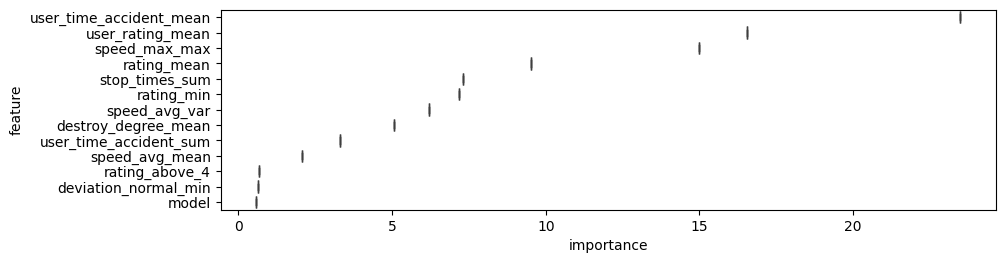

In [39]:
def plot_importance(df, best_model, height = 0.2, top_n=50):

    fi = pd.DataFrame(index=df.columns, columns=[])
    for i, m in enumerate(best_model):
        fi[f"m_{i}"] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:, [0, 2]]  # .to_frame()
    fi.columns = ["feature", "importance"]

    cols_ord = list(fi.groupby("feature")["importance"].mean().sort_values(ascending=False).index)
    
    print("Всего признаков {}. Усреднее по {} моделям: ".format(len(cols_ord), len(best_model)))
    cols_ord = cols_ord[:top_n]

    fi = fi[fi["feature"].isin(cols_ord)]

    plt.figure(figsize=(10, len(cols_ord) * height))
    b = sns.boxplot(data=fi, y="feature", x="importance", orient="h", order=cols_ord)

    print("На график нанесено топ-{} признаков".format(top_n))
    return (
        fi.groupby(by=["feature"], as_index=False)["importance"]
        .mean()
        .sort_values(by="importance", ascending=False))


df_feats_imp = plot_importance(
    train[filtered_features].drop(targets, axis=1, errors="ignore"),
    best_model = [clf],
    height = 0.20,
    top_n=13,
)

На данном графике можно увидеть, что:
- user_time_accident_mean (среднее число инцидентов водителя)
- user_rating_mean (средний рейтинг водителя)
- speed_max_max (максимальная скорость)
- rating_mean (средний рейтинг, поставленный водителем)

являются самыми важными по мнению нашей модели.

Визуально выглядит, что наша модель работает достаточно корректно.

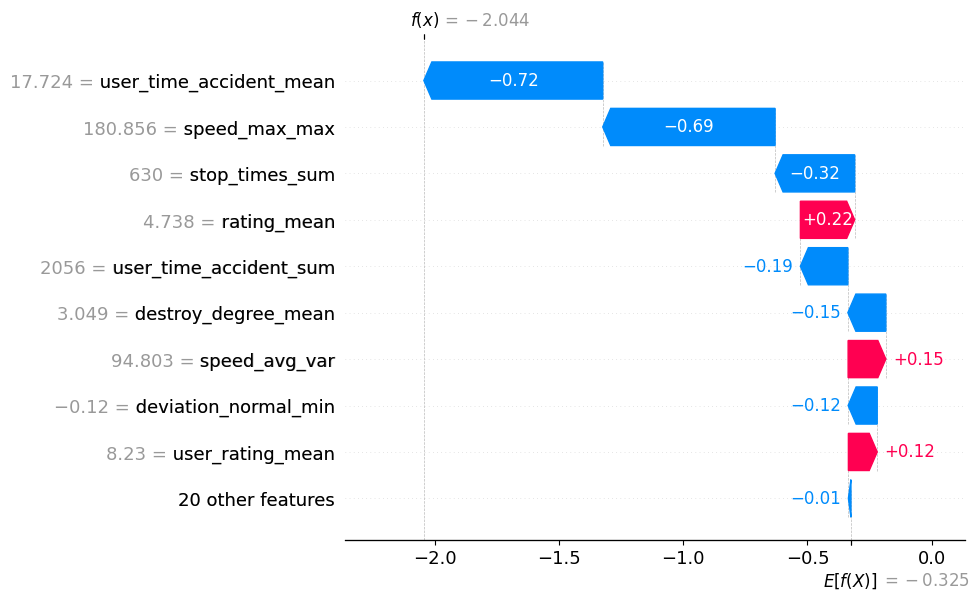

In [40]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X)
exp = Explanation(shap_values.values[:,:,1], 
                  shap_values.base_values[:,1], 
                  data=X.values, 
                  feature_names=X.columns)
idx = 0
shap.plots.waterfall(exp[idx])

Полученную нами схему будем читать снизу вверх. Признаки упорядочены по возрастанию их SHAP values.

- SHAP value `+0.12` для признака `user_rating_mean` (имеющего значение 8.23) говорит о том, что значение `user_rating_mean=8.23` на данном примере *увеличивает* величину предсказания модели, по сравнению с отсутствием признака user_rating_mean, при произвольном наличии других признаков
- SHAP value `-0.12` для признака `deviation_normal_mean` (имеющего значение -0.12) говорит о том, что значение `deviation_normal_mean=-0.12` *уменьшает* величину предсказания модели, по сравнению с отсутствием признака
- SHAP value `+0.15` для признака `speed_avg_var` говорит о том, что значение `speed_avg_var=94.803` *увеличивает* величину предсказания модели, по сравнению с отсутствием признака
- SHAP value `-0.15` для признака `destroy_degree_mean` говорит о том, что значение `destroy_degree_mean=3.049` *уменьшает* величину предсказания модели, по сравнению с отсутствием признака
- SHAP value `-0.19` для признака `user_time_accident_sum` говорит о том, что значение `user_time_accident_sum=2056` *уменьшает* величину предсказания модели, по сравнению с отсутствием признака
- SHAP value `+0.22` для признака `rating_mean` говорит о том, что значение `rating_mean=4.738` *увеличивает* величину предсказания модели, по сравнению с отсутствием признака
- SHAP value `-0.32` для признака `stop_times_sum` говорит о том, что значение `stop_times_sum=630` *уменьшает* величину предсказания модели, по сравнению с отсутствием признака
- SHAP value `-0.69` для признака `speed_max_max` говорит о том, что значение `speed_max_max=180.856` *уменьшает* величину предсказания модели, по сравнению с отсутствием признака
- SHAP value `-0.72` для признака `user_time_accident_mean` говорит о том, что значение `user_time_accident_mean=17.724` *уменьшает* величину предсказания модели, по сравнению с отсутствием признака

In [41]:
cb_pred = clf.predict(X_test)
print(classification_report(y_test,cb_pred))

                 precision    recall  f1-score   support

    another_bug       0.97      0.98      0.97        58
      break_bug       0.98      1.00      0.99        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       1.00      0.98      0.99        49
    engine_fuel       0.98      1.00      0.99        58
engine_ignition       1.00      1.00      1.00        58
engine_overheat       1.00      1.00      1.00        48
     gear_stick       1.00      0.98      0.99        51
    wheel_shake       0.97      0.95      0.96        39

       accuracy                           0.99       468
      macro avg       0.99      0.99      0.99       468
   weighted avg       0.99      0.99      0.99       468



По данной метрике мы уже давали интерпретацию (выше). Продублируем ее здесь.

Для оценки качества обучения, по условию, используем метрику `accuracy`.<br/>
Наша `CatBoostClassifier` модель показывает точность: 0.99<br/>

Видно, что модель ошиблась на:

- wheel_shake
- another_bug

и чуть меньше на:

- break_bug
- engine_check
- engine_fuel
- gear_stick

Результаты достаточно неплохие, но это не означает, что на реальных тестовых данных (в общем случае) результат будет аналогичен. 

[[57.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0. 56.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 51.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 48.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 58.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 58.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 48.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0. 50.  0.]
 [ 2.  0.  0.  0.  0.  0.  0.  0. 37.]]


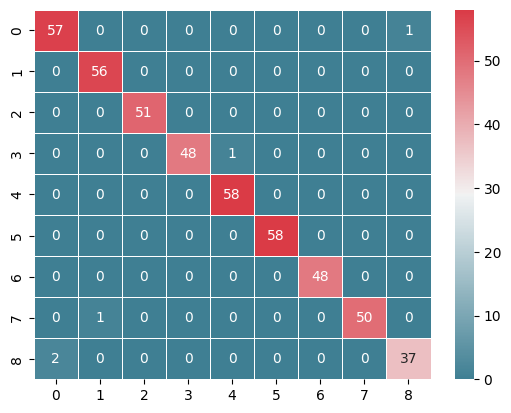

catboost Acc :  1.0


In [42]:
eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
cm = get_confusion_matrix(clf, eval_dataset)
print(cm)

predict_accuracy_on_test_set = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1]+cm[1,0] + cm[0,1])
ax = sns.heatmap(cm, linewidth=0.5, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True)
plt.show()

print("catboost Acc : ", predict_accuracy_on_test_set)

Исследуем полученную confusion_matrix.

- в первом классе `0` было **58** объектов. Из них модели удалось правильно идентифицировать **57**, отмеченных как `0`, но один был отмечен как `8`
- во втором классе `1` было **56** объектов. Из них модели удалось правильно идентифицировать все **56**
- в третьем классе `2` был **51** объект. Из них модели удалось правильно идентифицировать все **51**
- в четвертом классе `3` было **49** объектов. Из них модели удалось правильно идентифицировать **48**, отмеченных как `3`, но один был отмечен как `4`
- в пятом классе `4` было **58** объектов. Из них модели удалось правильно идентифицировать все **58**
- в шестом классе `5` было также **58** объектов. Из них модели удалось правильно идентифицировать все **58**
- в седьмом классе `6` было **48** объектов. Из них модели удалось правильно идентифицировать все **48**
- в восьмом классе `7` был **51** объект. Из них модели удалось правильно идентифицировать **50**, отмеченных как `7`, но один был отмечен как `1`
- в последнем, девятом классе `8` было **39** объектов. Из них модели удалось правильно идентифицировать **37**, отмеченных как `8`, но два были отмечены как `0`

Таким образом, мы проинтерпретировали все используемые методы/графики, как это и требовалось по условию.

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

In [46]:
def fit_catboost(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'iterations' : 400, # Можно не перебирать, есть Early-Stopping
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 50),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.8),
        
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced", "None"]),
        "depth": trial.suggest_int("depth", 3, 9),
        
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "30gb",
        "eval_metric": "Accuracy", # Тоже стоит заранее определиться
    }

    
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 20)
        
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        

    clf = CatBoostClassifier(
        **param,
        thread_count=-1,
        random_seed=42,
        cat_features=cat_features,
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=0,
        plot=False,
        early_stopping_rounds=5,
    )

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [38]:
def objective(trial, return_models=False):
    n_splits = 1
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    X_train = train[filtered_features].drop(targets, axis=1, errors="ignore")
    y_train = train["target_class"]

    scores, models = [], []
    
    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_catboost(trial, train_data, valid_data) # Определили выше
        scores.append(accuracy_score(y_pred, valid_data[1]))
        models.append(model)
         

    result = np.mean(scores)
    
    if return_models:
        return result, models
    else:
        return result

In [47]:
study = optuna.create_study(direction="maximize")
study.optimize(objective,
               n_trials=50,
               n_jobs = -1,
               show_progress_bar=True,)

[I 2024-03-31 19:43:53,394] A new study created in memory with name: no-name-dcbfa5b8-c93f-486c-aec0-21e080ae3e87


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-03-31 19:43:57,171] Trial 5 finished with value: 0.7932937940166633 and parameters: {'learning_rate': 0.009274899459834032, 'l2_leaf_reg': 17, 'colsample_bylevel': 0.0415604701562104, 'auto_class_weights': 'Balanced', 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9457057606949287}. Best is trial 5 with value: 0.7932937940166633.
[I 2024-03-31 19:43:58,473] Trial 18 finished with value: 0.8990147151880192 and parameters: {'learning_rate': 0.00927071938084911, 'l2_leaf_reg': 31, 'colsample_bylevel': 0.19488232300117453, 'auto_class_weights': 'None', 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5481576600296647}. Best is trial 18 with value: 0.8990147151880192.
[I 2024-03-31 19:43:59,587] Trial 21 finished with value: 0.975182951123194 and parameters: {'learning_rate': 0.00755716214420045, 'l2_leaf_reg': 41, 'colsample_bylevel': 0.05803513875606026, 'auto_class_weights': 'Balanced', 'depth': 9, 'boostin

In [48]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.985022982410912, params {'learning_rate': 0.007375935462384232, 'l2_leaf_reg': 35, 'colsample_bylevel': 0.4666528194545658, 'auto_class_weights': 'SqrtBalanced', 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}


In [49]:
valid_scores, models = objective(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True,
)

In [50]:
valid_scores, len(models)

(0.985022982410912, 2)

In [51]:
trials_df = study.trials_dataframe().sort_values('value', ascending=False)
trials_df.head(3)

,number,value,datetime_start,datetime_complete,duration,params_auto_class_weights,params_bagging_temperature,params_boosting_type,params_bootstrap_type,params_colsample_bylevel,params_depth,params_l2_leaf_reg,params_learning_rate,params_subsample,state
48,48,0.985023,2024-03-31 19:44:30.755174,2024-03-31 19:44:44.422978,0 days 00:00:13.667804,SqrtBalanced,NaN,Plain,MVS,0.466653,5,35,0.007376,NaN,COMPLETE
27,27,0.983741,2024-03-31 19:44:00.933879,2024-03-31 19:44:11.266107,0 days 00:00:10.332228,Balanced,NaN,Ordered,MVS,0.387219,3,48,0.006208,NaN,COMPLETE
45,45,0.983740,2024-03-31 19:44:24.618007,2024-03-31 19:44:44.704261,0 days 00:00:20.086254,Balanced,NaN,Plain,MVS,0.442970,8,36,0.007073,NaN,COMPLETE


In [52]:
optuna.visualization.plot_param_importances(study)

На основании полученного нами графика можно сделать вывод, что существует как минимум шесть важных гиперпараметров:
- colsample_bylevel
- bootstrap_type
- depth
- learning_rate
- l2_leaf_reg
- auto_class_weights

Согласно условию нам нужно выбрать минимум три из них, что и сделаем.

In [54]:
param = {
        'iterations' : 100, 
        "colsample_bylevel": 0.4666528194545658,
        "learning_rate": 0.007375935462384232,
        "depth": 5,
        "used_ram_limit": "30gb",
        "eval_metric": "Accuracy", 
    }

clf2 = CatBoostClassifier(
    **param,
    random_seed=42,
    cat_features=cat_features)

clf2.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=50,
)

0:	learn: 0.7560193	test: 0.7628205	best: 0.7628205 (0)	total: 26.8ms	remaining: 2.65s


99:	learn: 0.9839486	test: 0.9871795	best: 0.9893162 (83)	total: 3.26s	remaining: 0us

bestTest = 0.9893162393
bestIteration = 83

Shrink model to first 84 iterations.


In [55]:
class_predictions = clf2.predict(X_test)
class_report = classification_report(y_test, class_predictions)

print(f'Classification Report:\n {class_report}')

Classification Report:
                  precision    recall  f1-score   support

    another_bug       0.95      1.00      0.97        58
      break_bug       1.00      1.00      1.00        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       0.98      1.00      0.99        49
    engine_fuel       0.98      1.00      0.99        58
engine_ignition       1.00      1.00      1.00        58
engine_overheat       1.00      0.98      0.99        48
     gear_stick       1.00      0.98      0.99        51
    wheel_shake       1.00      0.92      0.96        39

       accuracy                           0.99       468
      macro avg       0.99      0.99      0.99       468
   weighted avg       0.99      0.99      0.99       468



Сравним с теми результатами, которые были получены ранее:

```text
                 precision    recall  f1-score   support

    another_bug       0.97      0.98      0.97        58
      break_bug       0.98      1.00      0.99        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       1.00      0.98      0.99        49
    engine_fuel       0.98      1.00      0.99        58
engine_ignition       1.00      1.00      1.00        58
engine_overheat       1.00      1.00      1.00        48
     gear_stick       1.00      0.98      0.99        51
    wheel_shake       0.97      0.95      0.96        39

       accuracy                           0.99       468
      macro avg       0.99      0.99      0.99       468
   weighted avg       0.99      0.99      0.99       468
```   

Согласно полученному результату, использование Optuna, как и подбор с ее помощью гиперпараметров, оказали положительное влияние. Точность модели немного возросла. Особенно это заметно по:
- break_bug
- engine_overheat

Также стоит отметить, что Optuna помогла нам получить новые гиперпараметры, влияющие на качество, а значит мы смогли сократить диапазон значений, которые мы перебираем и тем самым быстрее достигли необходимых результатов.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017


In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.